# MVI semestral project


MVI semestral project description


In [ ]:
!nvidia-smi

Thu Dec 22 16:07:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Subset, TensorDataset, DataLoader
from torch.autograd import Variable

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

import itertools

In [ ]:
!wget 'https://raw.githubusercontent.com/zapotocnylubos/cycle-gan/main/images.tar.gz' -O /content/images.tar.gz
!rm -rf /content/images
!tar -xf /content/images.tar.gz -C /content 2>/dev/null
!ls -l /content/images

--2022-12-22 16:07:39--  https://raw.githubusercontent.com/zapotocnylubos/cycle-gan/main/images.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101067850 (96M) [application/octet-stream]
Saving to: ‘/content/images.tar.gz’

/content/images.tar 100%[===================>]  96.39M   303MB/s    in 0.3s    

2022-12-22 16:07:44 (303 MB/s) - ‘/content/images.tar.gz’ saved [101067850/101067850]

total 272
drwxr-xr-x 2 501 staff  12288 Dec 22 16:07 painting
drwxr-xr-x 2 501 staff 266240 Nov 30 13:53 photo


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
timestamp = int(time.time())
GOOGLE_DRIVE_CHECKPOINT_DIRECTORY = f'/content/gdrive/MyDrive/Colab Notebooks/MVI-semestral/checkpoints/{timestamp}'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
IMAGE_CHANNELS = 3
IMAHE_HEIGHT = 256
IMAGE_WIDTH = 256

IMAGES_DIRECTORY = '/content/images'

In [ ]:
images = ImageFolder(IMAGES_DIRECTORY, transform=transforms.Compose([
  transforms.ToTensor()
  # TODO: normalize? transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
]))

paintings = Subset(images, [
  index for index in range(len(images)) if images.imgs[index][1] == images.class_to_idx['painting']
])

photos = Subset(images, [
  index for index in range(len(images)) if images.imgs[index][1] == images.class_to_idx['photo']
])

print(len(images), 'images', len(paintings), 'paintings', len(photos), 'photos')


7478 images 300 paintings 7178 photos


In [ ]:
PAINTINGS_BATCH_SIZE = 1
PHOTOS_BATCH_SIZE = 1

paintings_dataloader = DataLoader(
  paintings,
  batch_size=PAINTINGS_BATCH_SIZE,
  shuffle=True,
  drop_last=True, pin_memory=True
)

photos_dataloader = DataLoader(
  photos, 
  batch_size=PHOTOS_BATCH_SIZE,
  shuffle=True,
  drop_last=True, pin_memory=True
)

In [ ]:
grid_photo_dataloader = DataLoader(
  photos,
  batch_size=4,
  drop_last=True, pin_memory=True
)

In [ ]:
class Generator(nn.Module):
  """Generator for transfering paintings to photos"""

  def __init__(self):
      super().__init__()

      self.model = nn.Sequential(
        # downsampling

        nn.ReflectionPad2d(3),
        nn.Conv2d(3, 64, kernel_size=7),
        nn.InstanceNorm2d(64),
        nn.ReLU(inplace=True),
        
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace=True),

        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),

        # resnet blocks

        # resnet block 1
        nn.ReflectionPad2d(1),
        nn.Conv2d(256, 256, kernel_size=3),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),
        nn.ReflectionPad2d(1),
        nn.Conv2d(256, 256, kernel_size=3),
        nn.InstanceNorm2d(256),

        # resnet block 2
        nn.ReflectionPad2d(1),
        nn.Conv2d(256, 256, kernel_size=3),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),
        nn.ReflectionPad2d(1),
        nn.Conv2d(256, 256, kernel_size=3),
        nn.InstanceNorm2d(256),

        # resnet block 3
        nn.ReflectionPad2d(1),
        nn.Conv2d(256, 256, kernel_size=3),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),
        nn.ReflectionPad2d(1),
        nn.Conv2d(256, 256, kernel_size=3),
        nn.InstanceNorm2d(256),

        # resnet block 4
        nn.ReflectionPad2d(1),
        nn.Conv2d(256, 256, kernel_size=3),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),
        nn.ReflectionPad2d(1),
        nn.Conv2d(256, 256, kernel_size=3),
        nn.InstanceNorm2d(256),

        # resnet block 5
        nn.ReflectionPad2d(1),
        nn.Conv2d(256, 256, kernel_size=3),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),
        nn.ReflectionPad2d(1),
        nn.Conv2d(256, 256, kernel_size=3),
        nn.InstanceNorm2d(256),

        # resnet block 6
        nn.ReflectionPad2d(1),
        nn.Conv2d(256, 256, kernel_size=3),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),
        nn.ReflectionPad2d(1),
        nn.Conv2d(256, 256, kernel_size=3),
        nn.InstanceNorm2d(256),

        # upsampling

        nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.InstanceNorm2d(64),
        nn.ReLU(inplace=True),

        nn.ReflectionPad2d(3),
        nn.Conv2d(64, 3, kernel_size=7),

        nn.Tanh()
      )
  
  def forward(self, input):
      return self.model(input)

In [ ]:
class Discriminator(nn.Module):
  """Discriminator for paintings"""
 
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
      nn.LeakyReLU(0.2, inplace=True),


      nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
      nn.InstanceNorm2d(128),
      nn.LeakyReLU(0.2, inplace=True),


      nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
      nn.InstanceNorm2d(256),
      nn.LeakyReLU(0.2, inplace=True),


      nn.Conv2d(256, 512, kernel_size=4, padding=1),
      nn.InstanceNorm2d(512),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(512, 1, kernel_size=4, padding=1),
    )
  
  def forward(self, x):
    return self.model(x)

In [ ]:
class CycleGAN:
  def __init__(self, device):
    self.device = device

    # paintings (B) -> photos (A)
    self.generator_painting = Generator().to(self.device)
    self.discriminator_painting = Discriminator().to(self.device)

    # photos (A) -> paintings (B)
    self.generator_photo = Generator().to(self.device)
    self.discriminator_photo = Discriminator().to(self.device)

    self.generators_parameters = itertools.chain(
        self.generator_photo.parameters(),
        self.generator_painting.parameters()
    )

    self.discriminators_params = itertools.chain(
        self.discriminator_photo.parameters(),
        self.discriminator_painting.parameters()
    )

    self.generators_optimizer = optim.Adam(
        self.generators_parameters,
        lr=0.0002, betas=(0.5, 0.999)
    )

    self.discriminators_optimizer = optim.Adam(
        self.discriminators_params,
        lr=0.0002, betas=(0.5, 0.999)
    )

    self.criterion_generator = nn.MSELoss().to(self.device)
    self.criterion_discriminator = nn.MSELoss().to(self.device)

    self.criterion_cycle = nn.L1Loss().to(self.device)
    self.criterion_identity = nn.L1Loss().to(self.device)

  def train_epoch(self, paintings_dataloader, photos_dataloader):
    for i, ((painting, _), (photo, _)) in enumerate(zip(itertools.cycle(paintings_dataloader), photos_dataloader)):
      painting = painting.to(self.device)
      photo = photo.to(self.device)

      # TRAIN GENERATORS

      # photo (A) -> painting (B)
      
      fake_painting = self.generator_photo(photo)
      discriminator_painting_fake_decision = self.discriminator_painting(fake_painting)
      generator_photo_loss = self.criterion_generator(
          discriminator_painting_fake_decision, 
          Variable(torch.ones(discriminator_painting_fake_decision.size()).to(self.device))
      )

      # cycle loss

      recon_photo = self.generator_painting(fake_painting)
      cycle_photo_loss = self.criterion_cycle(recon_photo, photo) * 10

      # painting (B) -> photo (A)

      fake_photo = self.generator_painting(painting)
      discriminator_photo_fake_decision = self.discriminator_photo(fake_photo)
      generator_painting_loss = self.criterion_generator(
          discriminator_photo_fake_decision, 
          Variable(torch.ones(discriminator_photo_fake_decision.size()).to(self.device))
      )

      # cycle loss

      recon_painting = self.generator_photo(fake_photo)
      cycle_painting_loss = self.criterion_cycle(recon_painting, painting) * 10

      # back propagation

      generator_loss = generator_photo_loss + generator_painting_loss + cycle_photo_loss + cycle_painting_loss
      self.generators_optimizer.zero_grad()
      generator_loss.backward()
      self.generators_optimizer.step()

      # TRAIN DISCRIMINATORS

      # photo discriminator
      
      discriminator_photo_real_decision = self.discriminator_photo(photo)
      discriminator_photo_real_loss = self.criterion_discriminator(
          discriminator_photo_real_decision, 
          Variable(torch.ones(discriminator_photo_real_decision.size()).to(self.device))
      )

      fake_photo = self.generator_painting(painting)

      discriminator_photo_fake_decision = self.discriminator_photo(fake_photo)
      discriminator_photo_fake_loss = self.criterion_discriminator(
          discriminator_photo_fake_decision,
          Variable(torch.zeros(discriminator_photo_fake_decision.size()).to(self.device))
      )

      # back propagation

      discriminator_photo_loss = 0.5 * (discriminator_photo_real_loss + discriminator_photo_fake_loss)
      self.discriminators_optimizer.zero_grad()
      discriminator_photo_loss.backward()
      self.discriminators_optimizer.step()

      # painting discriminator

      discriminator_painting_real_decision = self.discriminator_painting(painting)
      discriminator_painting_real_loss = self.criterion_discriminator(
          discriminator_painting_real_decision,
          Variable(torch.ones(discriminator_painting_real_decision.size()).to(self.device))
      )

      fake_painting = self.generator_photo(photo)

      discriminator_painting_fake_decision = self.discriminator_painting(fake_painting)
      discriminator_painting_fake_loss = self.criterion_discriminator(
          discriminator_painting_fake_decision,
          Variable(torch.zeros(discriminator_painting_fake_decision.size()).to(self.device))
      )

      # back propagation

      discriminator_painting_loss = 0.5 * (discriminator_painting_real_loss + discriminator_painting_fake_loss)
      self.discriminators_optimizer.zero_grad()
      discriminator_painting_loss.backward()
      self.discriminators_optimizer.step()

      if (i + 1) % 250 == 0 or i + 1 == len(photos_dataloader):
        print(f'step [{i+1}/{len(photos_dataloader)}]')
      
      if i + 1 == len(photos_dataloader):
        print("Discriminators losses", discriminator_painting_loss.item(), discriminator_photo_loss.item())
        print("Generators losses", generator_painting_loss.item(), generator_photo_loss.item())

  def load_checkpoint(self, checkpoint):
    checkpoint = torch.load(checkpoint)

    self.generator_painting.load_state_dict(checkpoint['generator_painting'])
    self.discriminator_painting.load_state_dict(checkpoint['discriminator_painting'])
    
    self.generator_photo.load_state_dict(checkpoint['generator_photo'])
    self.discriminator_photo.load_state_dict(checkpoint['discriminator_photo'])

    self.generators_optimizer.load_state_dict(checkpoint['generators_optimizer'])
    self.discriminators_optimizer.load_state_dict(checkpoint['discriminators_optimizer'])

  def save_checkpoint(self, checkpoint):
    if not os.path.exists(os.path.dirname(checkpoint)):
      os.makedirs(os.path.dirname(checkpoint))

    torch.save({      
      'generator_painting': self.generator_painting.state_dict(),
      'discriminator_painting': self.discriminator_painting.state_dict(),
      'generator_photo': self.generator_photo.state_dict(),
      'discriminator_photo': self.discriminator_photo.state_dict(),

      'generators_optimizer': self.generators_optimizer.state_dict(),
      'discriminators_optimizer': self.discriminators_optimizer.state_dict()
    }, checkpoint)



In [ ]:
def plot_epoch(photos, paintings, suptitle=None):
  plt.figure(figsize=(30, 15), facecolor='w')

  photos_grid = make_grid(photos, nrow=2)

  plt.subplot(1, 2, 1)
  plt.imshow(photos_grid.permute(1, 2, 0))
  plt.title("Photos")

  paintings_grid = make_grid(paintings, nrow=2, normalize=True)

  plt.subplot(1, 2, 2)
  plt.imshow(paintings_grid.permute(1, 2, 0))
  plt.title("Paintings")

  if suptitle is not None:
    plt.suptitle(suptitle)

  plt.show()

epoch 58
step [250/7178]
step [500/7178]
step [750/7178]
step [1000/7178]
step [1250/7178]
step [1500/7178]
step [1750/7178]
step [2000/7178]
step [2250/7178]
step [2500/7178]
step [2750/7178]
step [3000/7178]
step [3250/7178]
step [3500/7178]
step [3750/7178]
step [4000/7178]
step [4250/7178]
step [4500/7178]
step [4750/7178]
step [5000/7178]
step [5250/7178]
step [5500/7178]
step [5750/7178]
step [6000/7178]
step [6250/7178]
step [6500/7178]
step [6750/7178]
step [7000/7178]
step [7178/7178]
Discriminators losses 0.053266365081071854 0.01458945032209158
Generators losses 1.3009676933288574 1.2626405954360962
Training epoch 58 took 3467.5168 seconds


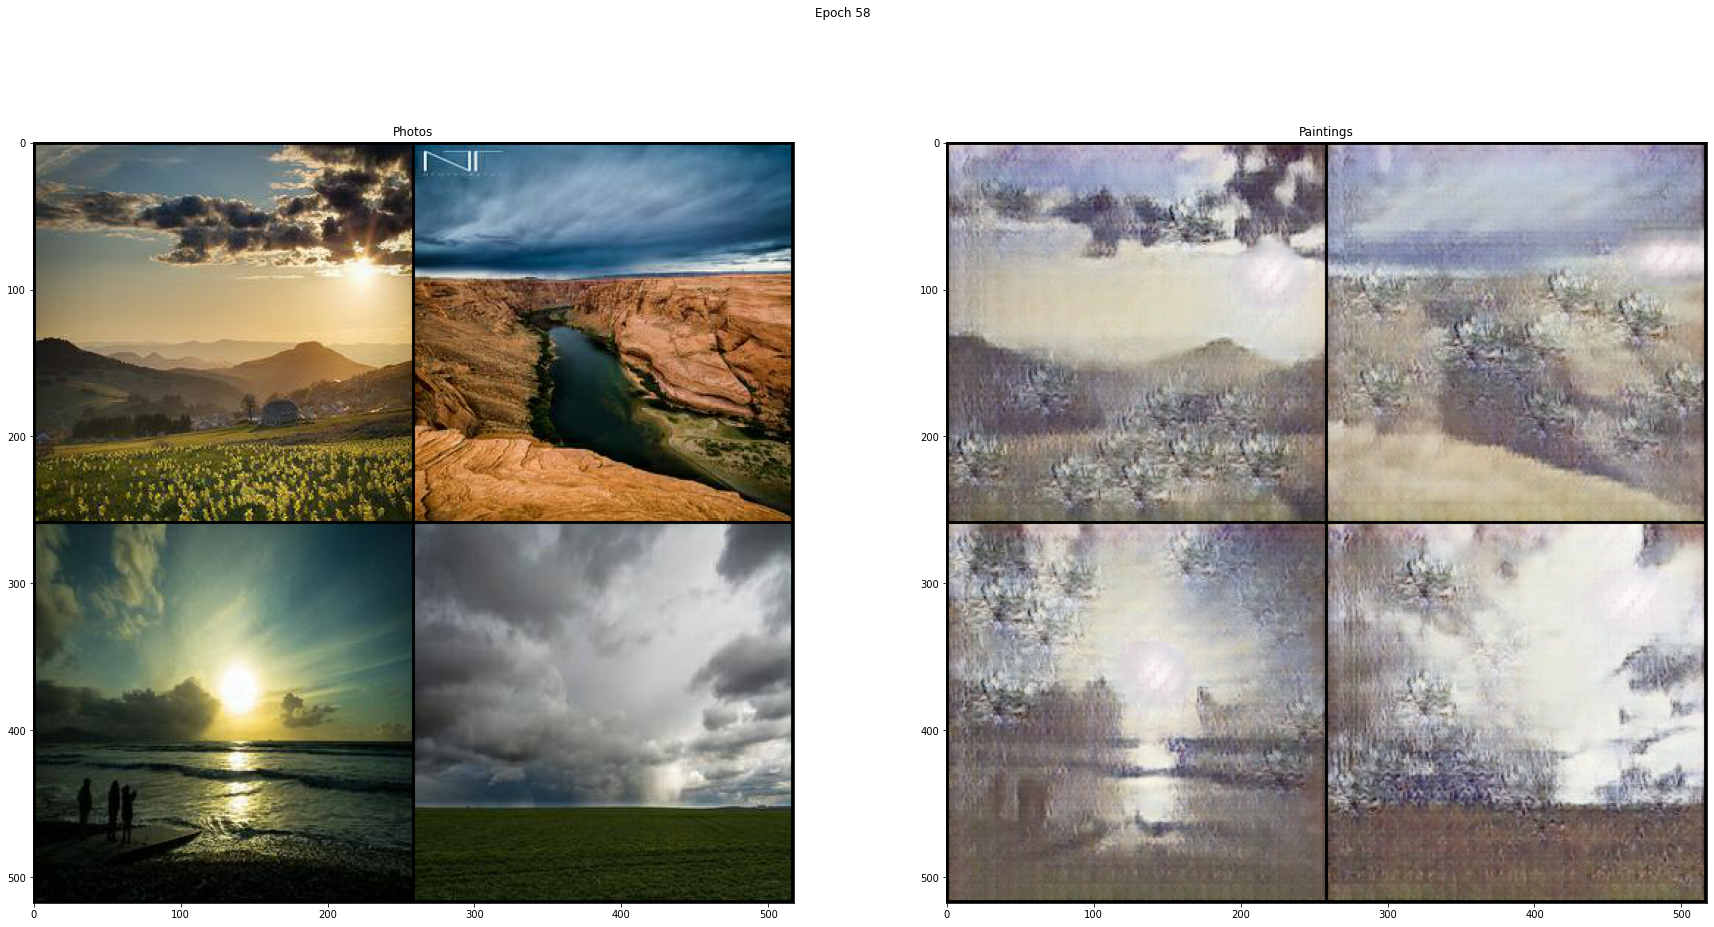

epoch 59
step [250/7178]
step [500/7178]
step [750/7178]
step [1000/7178]
step [1250/7178]
step [1500/7178]
step [1750/7178]
step [2000/7178]
step [2250/7178]
step [2500/7178]
step [2750/7178]
step [3000/7178]
step [3250/7178]
step [3500/7178]
step [3750/7178]
step [4000/7178]
step [4250/7178]
step [4500/7178]
step [4750/7178]
step [5000/7178]
step [5250/7178]
step [5500/7178]
step [5750/7178]
step [6000/7178]
step [6250/7178]
step [6500/7178]
step [6750/7178]
step [7000/7178]
step [7178/7178]
Discriminators losses 0.02615523338317871 0.02455858886241913
Generators losses 1.0229933261871338 1.0399746894836426
Training epoch 59 took 3471.3709 seconds


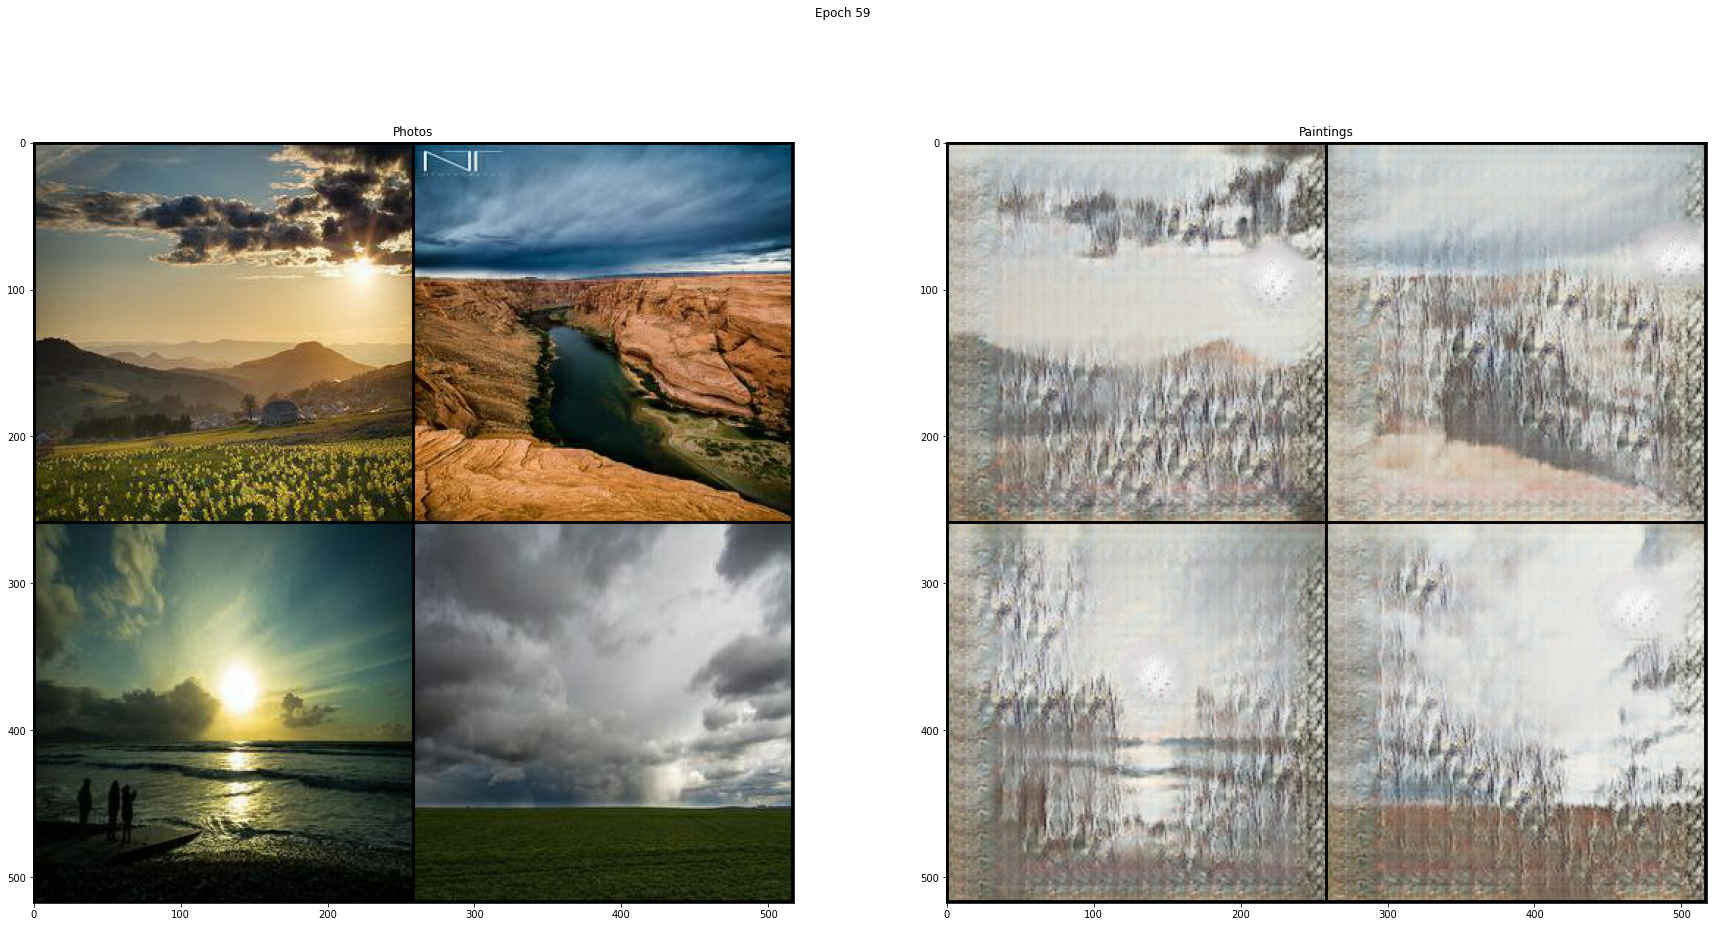

epoch 60
step [250/7178]
step [500/7178]
step [750/7178]
step [1000/7178]
step [1250/7178]
step [1500/7178]
step [1750/7178]
step [2000/7178]
step [2250/7178]
step [2500/7178]
step [2750/7178]
step [3000/7178]
step [3250/7178]
step [3500/7178]
step [3750/7178]
step [4000/7178]
step [4250/7178]
step [4500/7178]
step [4750/7178]
step [5000/7178]
step [5250/7178]
step [5500/7178]
step [5750/7178]
step [6000/7178]
step [6250/7178]
step [6500/7178]
step [6750/7178]
step [7000/7178]
step [7178/7178]
Discriminators losses 0.034749068319797516 0.08708630502223969
Generators losses 0.828679621219635 0.9340696930885315
Training epoch 60 took 3469.5438 seconds


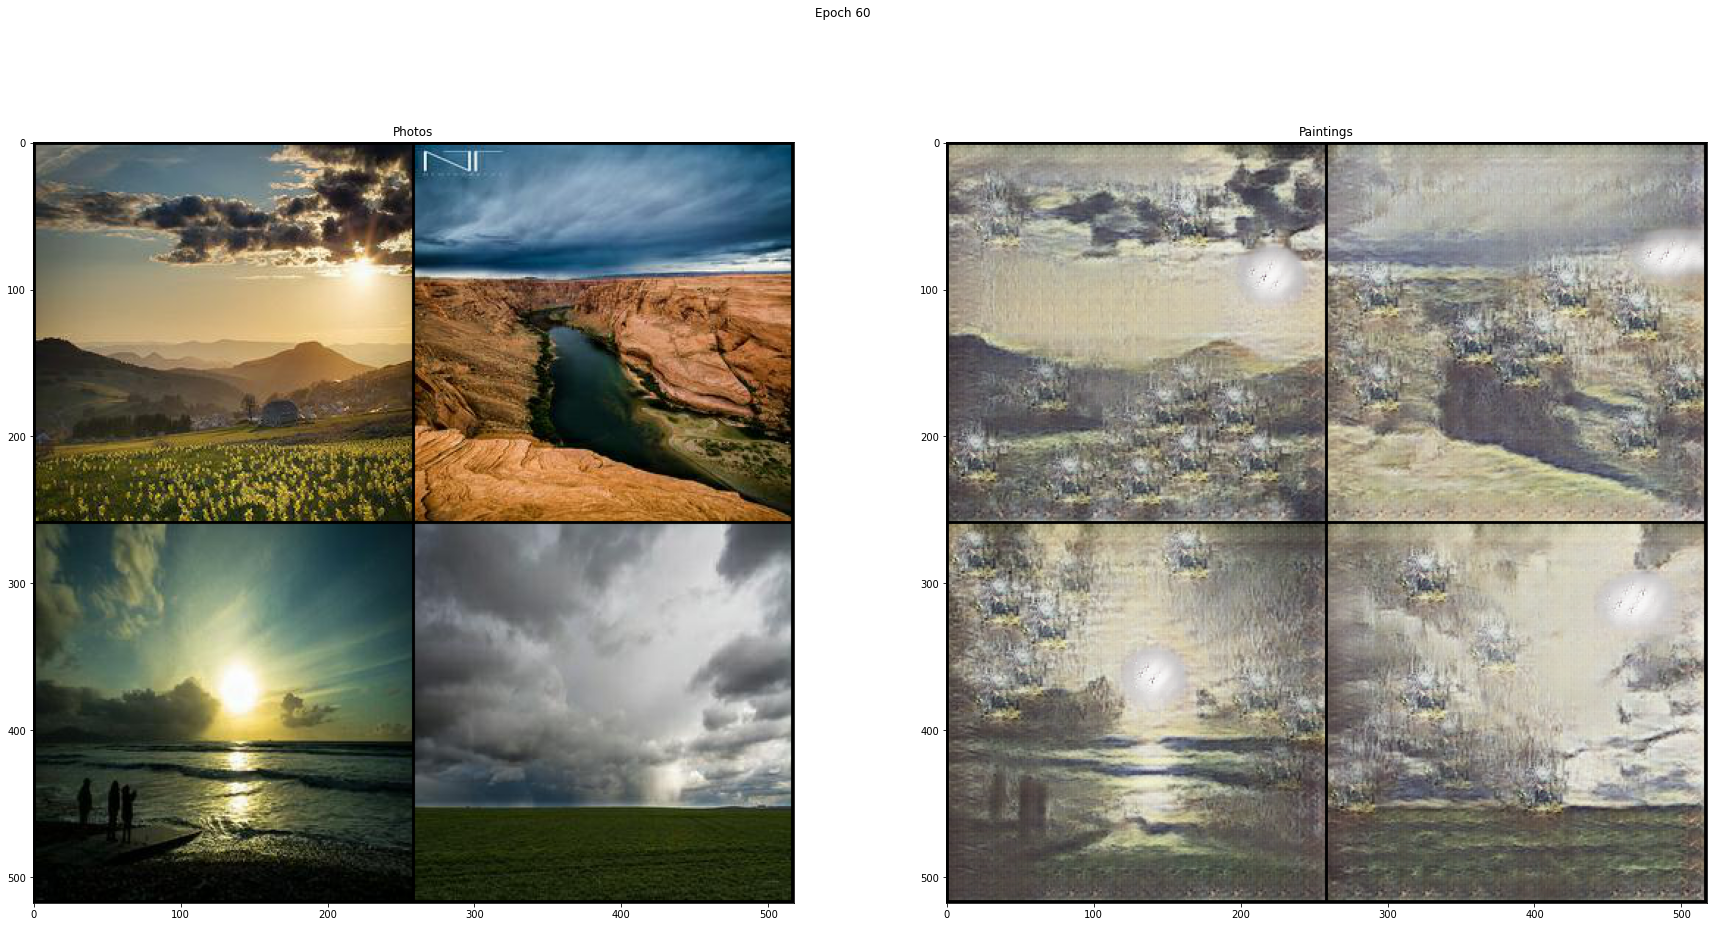

epoch 61
step [250/7178]
step [500/7178]
step [750/7178]
step [1000/7178]
step [1250/7178]
step [1500/7178]
step [1750/7178]
step [2000/7178]
step [2250/7178]
step [2500/7178]
step [2750/7178]
step [3000/7178]
step [3250/7178]
step [3500/7178]
step [3750/7178]
step [4000/7178]
step [4250/7178]
step [4500/7178]
step [4750/7178]
step [5000/7178]
step [5250/7178]
step [5500/7178]
step [5750/7178]
step [6000/7178]
step [6250/7178]
step [6500/7178]
step [6750/7178]
step [7000/7178]
step [7178/7178]
Discriminators losses 0.01058135274797678 0.030050944536924362
Generators losses 1.3994916677474976 1.0109062194824219
Training epoch 61 took 3470.5608 seconds


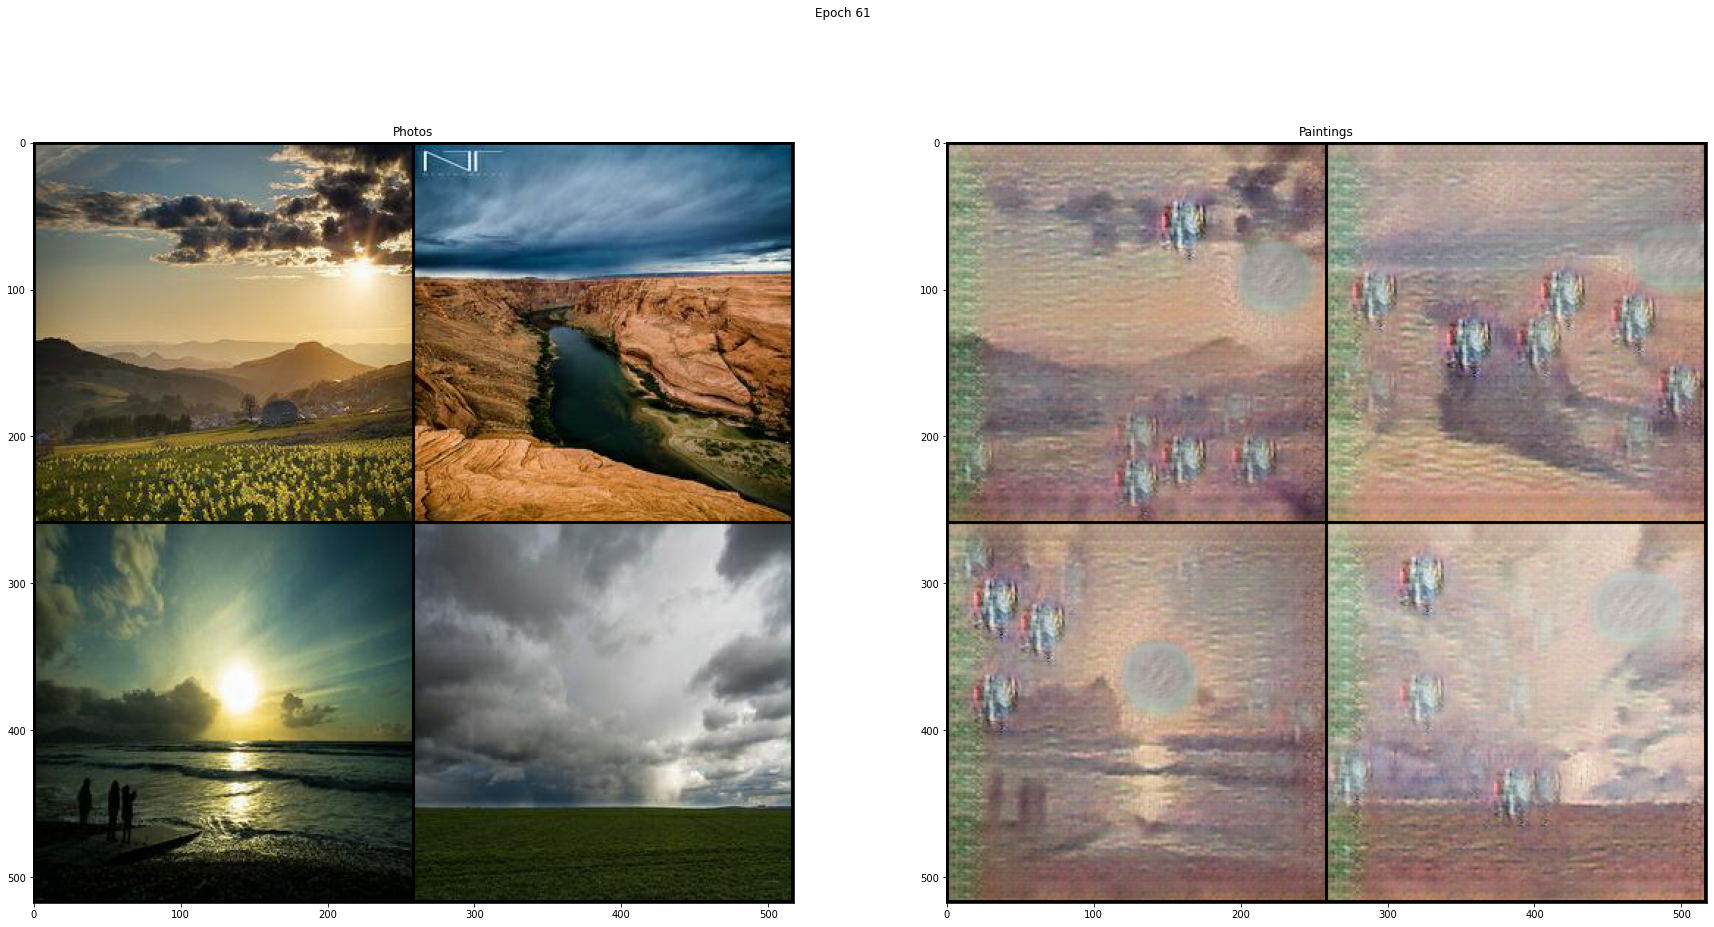

epoch 62
step [250/7178]


In [ ]:
model = CycleGAN(device)
model.load_checkpoint(f'/content/gdrive/MyDrive/Colab Notebooks/MVI-semestral/checkpoints/1671695511/epoch57.pt')

for epoch in range(58, 71):
  print('epoch', epoch)

  tic = time.perf_counter()
  model.train_epoch(paintings_dataloader, photos_dataloader)
  toc = time.perf_counter()

  print(f'Training epoch {epoch} took {toc - tic:0.4f} seconds')

  model.save_checkpoint(f'/images/epoch{epoch}.pt')

  if epoch % 5 == 0:
    model.save_checkpoint(f'{GOOGLE_DRIVE_CHECKPOINT_DIRECTORY}/epoch{epoch}.pt')
  
  photos = next(iter(grid_photo_dataloader))[0].to(device)
  paintings = model.generator_photo.forward(photos)

  plot_epoch(
      photos.detach().cpu(),
      paintings.detach().cpu(),
      suptitle=f'Epoch {epoch}'
  )

